In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname
!pwd
import sys
print(sys.executable)

oliva-titanrtx-1.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
import os, sys, glob, pickle
os.environ['JAX_DEBUG_NANS'] = 'True'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import optax
from flax import linen as nn
import jax.numpy as jnp
from flax.training.train_state import TrainState
import jax
from jax.random import split
from mdps.random_net import RandomMLP, create_random_net

from functools import partial

from agents.regular_transformer import BCTransformer
from tqdm.auto import tqdm

from typing import Callable

from einops import rearrange

In [3]:
rng = jax.random.PRNGKey(0)

2024-03-10 12:19:19.876442: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
from util import save_pkl, load_pkl
from icl_bc_ed import construct_dataset, sample_batch_from_dataset, augment_batch

In [5]:
dataset = construct_dataset(["../data/exp_icl/datasets/real/classic/name=CartPole-v1/dataset.pkl"], [], d_obs_uni=64, n_acts_uni=10)

Found 1 datasets
Loading dataset from /data/vision/phillipi/akumar01/synthetic-mdps/data/exp_icl/datasets/real/classic/name=CartPole-v1/dataset.pkl
Dataset shape: {'act': (4, 262144), 'done': (4, 262144), 'logits': (4, 262144, 2), 'obs': (4, 262144, 4), 'rew': (4, 262144)}


In [6]:
rng = jax.random.PRNGKey(0)
batch = sample_batch_from_dataset(rng, dataset, 8, 8)
batch = augment_batch(rng, batch, 1000000, 0, 0, 0, 0, 0)

In [7]:
agent = BCTransformer(n_acts=10, n_layers=4, n_heads=8, d_embd=256, n_steps=1024, mask_type='causal')

In [8]:
dataset = load_pkl("../data/exp_icl/datasets/real/classic/name=DiscretePendulum-v1/", "dataset")

In [9]:
print(jax.tree_map(lambda x: x.shape, dataset))

{'act': (4, 262144), 'done': (4, 262144), 'logits': (4, 262144, 5), 'obs': (4, 262144, 3), 'rew': (4, 262144)}


In [10]:
done = dataset['done']

In [11]:
done.shape

(4, 262144)

In [12]:
jnp.diff(jnp.where(done[0])[0]).mean()

Array(200., dtype=float32)

In [8]:
def plot_loss(loss, smooth_window=1, ylim=(0.99, 2.), logscale=True, text=True, **kwargs):
    assert loss.ndim == 1
    assert smooth_window % 2 == 1
    iters = len(loss)
    x = np.arange(iters)
    loss_smooth = np.convolve(loss, np.ones(smooth_window)/smooth_window, mode='valid')
    plt.plot(x, loss, alpha=0.3, c='gray')
    plt.plot(x[smooth_window//2:-(smooth_window//2)], loss_smooth, **kwargs)
    end_loss = loss_smooth[-1].item()
    if text:
        plt.text(iters, end_loss, f"{end_loss:.3f}", ha='right', va='center')
    if ylim is not None:
        plt.ylim(end_loss*ylim[0], end_loss*ylim[1])
    if logscale:
        plt.yscale('log')


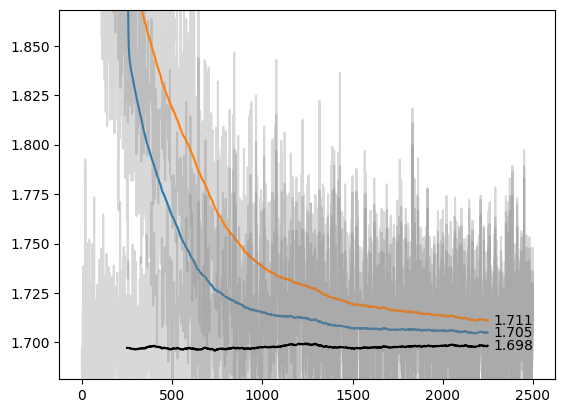

In [70]:
metrics = load_pkl("../data/exp_icl/temp/train/", "metrics_test")
plot_loss(np.e**metrics['ce'][:, -1], smooth_window=501, ylim=(0.999, 1.005), logscale=False)
metrics = load_pkl("../data/exp_icl/temp/train_zipf/", "metrics_test")
plot_loss(np.e**metrics['ce'][:, -1], smooth_window=501, ylim=(0.999, 1.005), logscale=False)
plot_loss(metrics['tar_ppl'][:, -1], smooth_window=501, ylim=(0.99, 1.1), logscale=False, c='black')
# plt.ylim(0.9, 2)

In [12]:
agent_params = load_pkl("../data/exp_icl/temp/train/", "ckpt_final")['params']

In [53]:
logits = jax.vmap(agent.apply, in_axes=(None, 0, 0))(agent_params, batch['obs'], batch['act'])
probs = jax.nn.softmax(logits, axis=-1)

In [57]:
act = batch['act'][:, 30:]
act_p = batch['act'][:, 29:-1]

hard = probs[:, 30:].argmax(axis=-1)
rng = jax.random.PRNGKey(0)
soft = jax.random.categorical(rng, logits[:, 30:], axis=-1)
act_p.shape, act.shape, hard.shape, soft.shape

((8, 994), (8, 994), (8, 994), (8, 994))

In [58]:
print((act==1-act_p).mean())
print((act==hard).mean())
print((act==soft).mean())

0.78822935
0.81338024
0.6544265


In [59]:
rng = jax.random.PRNGKey(2)
soft = jax.random.categorical(rng, batch['logits'][:, 30:], axis=-1)
print((act==soft).mean())


0.82004523


In [84]:
a = batch['logits'][0].argmax(axis=-1)[10:]
b = probs[0].argmax(axis=-1)[10:]
(a==b).sum()/len(a)

Array(0.84911245, dtype=float32)

In [79]:
a = batch['act'][0][10:]
ap = a[:-1]
an = a[1:]
an_hat = np.array([2, 9])[(ap==2).astype(int)]

In [80]:
(an== an_hat).sum()/len(an)

Array(0.798618, dtype=float32)

In [19]:
rng = jax.random.PRNGKey(0)
batch = sample_batch_from_dataset(rng, dataset, 8, 1024)
batch = augment_batch(rng, batch, 1000000, 0, 0, 0, 0, 0)

(0.0, 10.0)

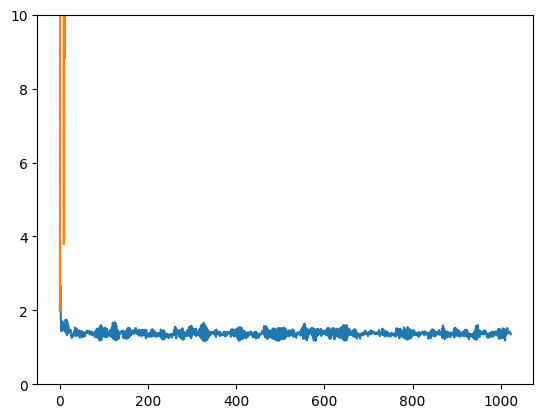

In [68]:
agent_params = load_pkl("../data/exp_icl/train_bc/name=CartPole-v1/", "ckpt_ 100000")['params']
logits = jax.vmap(agent.apply, in_axes=(None, 0, 0))(agent_params, batch['obs'], batch['act'])
ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits[..., :2]), jax.nn.softmax(batch['logits'][..., :2])).mean(axis=0)
plt.plot(np.e**ce)

agent_params = load_pkl("../data/exp_icl/train_bc/all-name=CartPole-v1", "ckpt_ 100000")['params']
logits = jax.vmap(agent.apply, in_axes=(None, 0, 0))(agent_params, batch['obs'], batch['act'])
ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits[..., :2]), jax.nn.softmax(batch['logits'][..., :2])).mean(axis=0)
plt.plot(np.e**ce)

# agent_params = load_pkl("../data/exp_icl/train_bc/name=csmdp;i_d=0;i_s=3;t_a=1;t_c=1;t_l=3;t_s=4;o_d=0;o_c=1;r_c=3;tl=64", "ckpt_ 100000")['params']
# logits = jax.vmap(agent.apply, in_axes=(None, 0, 0))(agent_params, batch['obs'], batch['act'])
# ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits[..., :2]), jax.nn.softmax(batch['logits'][..., :2])).mean(axis=0)
# plt.plot(np.e**ce)

plt.ylim(0, 10)


(900.0, 950.0)

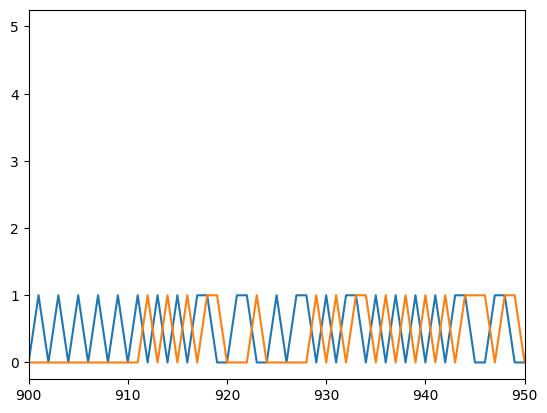

In [69]:
plt.plot(batch['act'][0])
plt.plot(logits[0].argmax(axis=-1))
plt.xlim(900, 950)